# **Input Data Creation**

# **Deriving James-Stein Shrinkage estimation Coefficient**

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

def alpha_numerator(Z,S):
  s = 0
  T = Z.shape[1]
  for k in range(T):
    z = Z[:,k][:,np.newaxis]
    X = z @ z.T - S
    s += np.trace(X @ X)
  s /= (T**2)
  return s


def mean_shrinkage_JS(m_estim,S_estim,return_array):
  T  = return_array.shape[0]
  N = m_estim.shape[0]
  m = m_estim[:,np.newaxis]
  o = np.ones(N)[:,np.newaxis]
  iS = np.linalg.inv(S_estim)
  b = (o.T @ m / N)*o
  N_eff = np.trace(S_estim)/ np.max(np.linalg.eigvalsh(S_estim))
  alpha_num = max(N_eff - 3,0) ## it should not get negative
  alpha_den = T * (m - b).T @ iS @ (m - b)
  alpha = alpha_num/alpha_den
  m_shrunk = b + max(1 - alpha, 0) * (m - b)
  m_shrunk = m_shrunk[:, 0]

  return m_shrunk


def cov_shrinkage_LW(m_estim,S_estim,return_array):
  N = S_estim.shape[0]
  s2_avg = np.trace(S_estim)/N
  B = s2_avg * np.eye(N)
  Z = return_array.T  - m_estim[:,np.newaxis]
  alpha_num = alpha_numerator(Z,S_estim)
  alpha_den = np.trace((S_estim - B) @ (S_estim - B))
  alpha = alpha_num/alpha_den
  S_shrunk = (1 - alpha) * S_estim + alpha * B

  return S_shrunk

**We will compute the distribution of linear return from the distribution of logarithmic return (advantage of scaling) using a pricing function P(h) = p0 * exp(R_log(W))**

In [ ]:
def compute_inputs(
        list_df_prices,
        sample_period='W',
        investment_horizon=1,
        show_histograms=False,
        shrinkage=False,
        security_num=None,
        return_log=False
    ):
    map_period = {
        'W': 52
    }

    # We can generate return distribution based on multiple periods of price data
    if not isinstance(list_df_prices, list):
        list_df_prices = [list_df_prices]

    df_weekly_log_returns = pd.DataFrame()
    for df_prices in list_df_prices:
        # PREPROC: Remove factors
        if security_num is not None:
            df_prices = df_prices.iloc[:, 0:security_num]

        # 1. Compute weekly logarithmic return
        df_weekly_prices = df_prices.resample(sample_period).last()
        df_weekly_log_returns_part = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
        df_weekly_log_returns_part = df_weekly_log_returns_part.dropna(how='all')
        df_weekly_log_returns_part = df_weekly_log_returns_part.fillna(0)

        df_weekly_log_returns = pd.concat([df_weekly_log_returns, df_weekly_log_returns_part], ignore_index=True)

    if show_histograms:
        df_weekly_log_returns.hist(bins=50)

    # 2. Compute the distribution of weekly logarithmic return
    return_array = df_weekly_log_returns.to_numpy()
    T = return_array.shape[0]
    m_weekly_log = np.mean(return_array, axis=0)
    S_weekly_log = np.cov(return_array.transpose())

    # Apply shrinkage if needed
    if shrinkage:
      m_weekly_log = mean_shrinkage_JS(m_weekly_log, S_weekly_log, return_array)
      S_weekly_log = cov_shrinkage_LW(m_weekly_log, S_weekly_log, return_array)

    # 3. Project the distribution to the investment horizon
    scale_factor = investment_horizon * map_period[sample_period]
    m_log = scale_factor * m_weekly_log
    S_log = scale_factor * S_weekly_log

    if return_log:
        return m_log, S_log

    # 4. Compute the distribution of yearly linear return
    p_0 = np.ones(len(m_log))  # We use a dummy price here to see the method in two steps. It will be canceled out later.
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)

    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P

    return m, S

# **Downloading the required Data**

In [ ]:
from datetime import datetime
import yfinance as yf
#import matplotlib.pyplot as plt

# initialize parameters
start_date = datetime(2021, 1, 1)
end_date = datetime(2022, 1, 1)

assets = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "FB", "TSLA", "BRK-A", "BRK-B", "JNJ",
    "JPM", "PG", "NVDA", "V", "MA", "HD", "DIS", "PYPL", "INTC", "UNH", "CRM",
    "BAC", "ADBE", "KO", "CMCSA", "NFLX", "NKE", "PEP", "XOM", "CSCO", "WMT",
    "ABBV", "ABT", "MRK", "CVX", "T", "MCD", "BABA", "ORCL", "IBM", "PM",
    "WFC", "VZ", "TMO", "COST", "PFE", "WBA", "C", "HON", "UPS", "NEE",
    "LIN", "LLY", "AMGN", "MDT", "UNP", "SBUX", "DHR", "ACN", "TXN", "AVGO",
    "LOW", "CAT", "QCOM", "GS", "CHTR", "INTU", "BKNG", "BDX", "RTX", "USB",
    "ISRG", "CI", "SYK", "BDX", "ADP", "ZTS", "LMT", "MMM", "AMD", "ANTM",
    "NOW", "CSX", "VRTX", "SCHW", "ZM", "CB", "RTX", "PLD", "TGT", "MU",
    "DE", "PNC", "ICE", "FDX", "APD", "TMUS", "CCI", "ILMN", "EW"
]

# get the data
raw_data = yf.download(assets, start = start_date,
                   end = end_date)

data = raw_data.loc[:,('Adj Close', slice(None))]
data_volume = raw_data.loc[:,('Volume', slice(None))]

scrip = []
try:
  for index in range(data.shape[0]-1):
    scrip.append(data.columns[index][1])
except:
  print("Index Out")

data.columns = scrip
data_volume.columns = scrip
data

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  98 of 98 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['ANTM', 'FB']: Exception('%ticker%: No timezone found, symbol may be delisted')


Index Out


,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,ANTM,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FB,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,127.002098,92.173607,103.105209,245.115570,485.339996,159.097137,92.300003,204.389343,159.331497,NaN,249.729431,391.186768,224.827728,27.922979,234.449051,2164.080078,343525.0,228.449997,53.118793,170.040024,142.306946,137.190857,647.030029,195.227219,46.646587,363.143188,220.309998,40.189526,28.243382,73.948402,257.993286,195.430481,177.102798,88.919998,NaN,240.263306,86.412003,86.306503,245.939224,245.347717,195.985229,101.472191,108.795425,367.760010,45.371323,364.220215,266.666656,143.276230,114.875877,48.158417,247.778183,158.981491,317.351135,151.289612,345.084076,196.562469,106.571251,148.233994,70.257317,211.605316,72.796799,69.310265,522.859985,135.820663,526.830017,130.840103,60.553726,132.712128,32.333984,127.131264,89.277626,69.568405,132.790298,231.919998,139.010666,63.610149,96.452766,50.570435,231.214828,17.343351,166.215622,468.583191,131.854401,243.256668,148.273880,335.248779,189.960190,147.621384,40.665344,212.716629,229.429993,48.899708,35.157166,27.566048,139.870651,36.027855,359.980011,159.686432
2021-01-05,128.572311,93.126755,104.380898,246.511017,485.690002,158.654587,92.769997,205.381256,160.925507,NaN,262.942230,393.836273,237.211243,28.136841,234.757675,2188.070068,341820.0,227.470001,54.496666,171.430939,142.421021,137.730743,636.590027,193.054047,46.368267,358.930511,221.520004,40.207806,28.721651,75.947479,264.393890,200.280548,177.860336,88.440002,NaN,240.253830,87.045998,87.002502,251.442657,247.327820,196.465912,103.273361,109.025887,374.899994,46.229969,361.447113,268.350006,144.960739,115.500946,47.629002,251.665070,159.769211,321.172516,151.799011,341.088348,197.740570,107.425514,147.983856,70.378822,211.809433,75.952461,69.823868,520.799988,136.916138,531.969971,133.746063,59.803337,133.107697,32.667782,127.943016,89.417053,70.328110,132.086990,234.910004,142.689514,64.530403,96.770859,50.580017,231.833908,17.237312,168.779541,474.442657,131.276932,245.036667,149.361572,330.740356,192.290146,145.566559,40.797604,209.541916,228.580002,48.675362,34.953358,28.336411,139.126099,37.764141,360.829987,160.799240
2021-01-06,124.244370,92.322266,104.163551,249.206268,466.309998,158.099030,90.330002,210.331818,156.919006,NaN,270.000153,391.407532,224.590897,29.894228,237.198456,2249.810059,346189.0,230.270004,57.632198,180.971481,149.197540,134.031006,624.510010,198.747971,46.906353,353.466309,216.149994,40.591789,29.485592,78.391762,279.894287,206.916580,178.538116,87.199997,NaN,240.614410,86.764503,86.143997,265.011078,248.740875,200.047241,105.852371,111.138420,376.549988,46.677563,353.735535,264.263336,146.324860,120.924385,46.113781,259.927216,157.847946,320.472656,153.827148,341.215912,197.291794,109.179955,150.234909,71.489609,206.317352,75.805000,73.241760,500.489990,138.001923,507.250000,125.861336,59.660316,131.479462,32.386688,129.289810,87.297623,70.421989,139.343018,226.830002,141.528748,65.329834,97.472496,55.027454,234.532822,17.573105,176.780121,481.881317,130.958328,251.993332,150.101913,344.620331,196.313721,145.133972,43.213539,207.695694,226.649994,49.265320,36.541370,30.341213,139.994736,38.727776,344.410004,163.161499
2021-01-07,128.483994,93.310371,105.174667,251.557465,477.739990,158.993576,95.160004,211.026169,158.108002,NaN,265.642517,407.902496,223.890305,30.554411,237.067535,2239.850098,350089.0,232.880005,58.312309,181.316895,148.133072,134.933807,629.770020,209.253372,46.999130,351.460388,217.979996,41.103752,30.182125,78.758408,288.926605,209.858154,177.99

**Removing the stocks with NAN values**

*Reasons behind it might be yahoo finance unable to fetch the data or the name of the stock on NYSE has changed*

In [ ]:
data.drop(['ANTM'],axis=1,inplace=True)
data.drop(['FB'],axis=1,inplace=True)

data_volume.drop(['ANTM'],axis=1,inplace=True)
data_volume.drop(['FB'],axis=1,inplace=True)

<ipython-input-6-8343caf241a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['ANTM'],axis=1,inplace=True)
<ipython-input-6-8343caf241a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(['FB'],axis=1,inplace=True)
<ipython-input-6-8343caf241a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_volume.drop(['ANTM'],axis=1,inplace=True)
<ipython-input-6-8343caf241a1>:5: SettingWithCopyWarning: 
A value is tryi

## **Getting Input Parameters**

# **To get G (risk matrix) we used cholesky's decomposition function so that we acquire a lower triangular matrix with minimum non-zero entries (Healthy for computation efficiency)**

In [ ]:
N = data.shape[1]

# Get optimization parameters
m, S = compute_inputs(data, security_num=N)
G = np.linalg.cholesky(S)

# **Installing and importing Mosek**

In [ ]:
! pip install mosek
from mosek.fusion import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 34.5 MB/s eta 0:00:00


# **Creating a return scenario (100 simulations) per stock using Multi Variate Normal Distribution (Monte Carlo Simulation)**

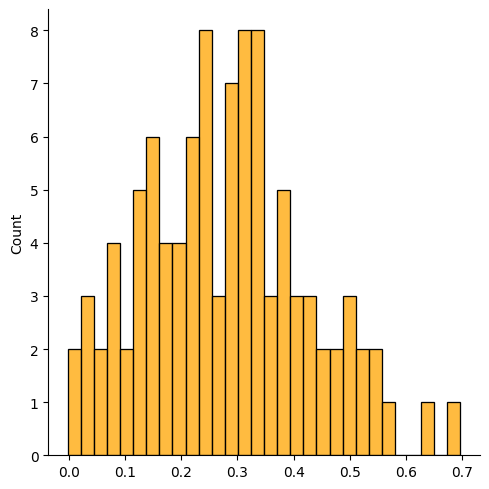

In [ ]:
import seaborn as sns
# Number of simulations
num_simulations = 100

m_log, s_log = compute_inputs(data,return_log=True)

np.random.seed(12345)
scenario_log = np.random.default_rng().multivariate_normal(m_log,s_log,num_simulations)

scenario_lin = np.exp(scenario_log) - 1

weights = np.array([1/N]*N)
portfolio_return = scenario_lin*weights
portfolio_return = portfolio_return.sum(axis=1)

sns.displot(portfolio_return,kde = False, color ='orange', bins = 30)

# **Calculating Value at Risk for alpha = 0.05**

In [ ]:
# Ensure sorted in ascending order (important for accurate VaR and EVaR)
sorted_returns = np.sort(portfolio_return)

# Calculate VaR threshold
var_index = int(len(sorted_returns) * 0.05)
var_threshold = sorted_returns[var_index]
print("Value AT Risk :", var_threshold)

Value AT Risk : 0.04716507926926147


# **Calculating Conditional Value AT Risk**

*CVaR for a normal distribution N(mu, sigma) is mu + (phi(Z_alpha) * std) /alpha*

citing :
**Amir Ahmadi-Javid1
and Malihe Fallah-Tafti (Portfolio Optimization with Entropic Value-at-Risk)**

In [ ]:
## we know that our returns (X) follow normal distribution hence the formula to calculate EVAR,VAR,CVAR changes (kindly refer notes)
## this formula comes from the research paper directly

CVAR = np.mean(portfolio_return) + (np.quantile(portfolio_return, .05) / 0.05) * np.std(portfolio_return)
print("CVAR :", CVAR)

CVAR : 0.4150888151918357


*CVaR calculation as provided by documentation guide*

In [ ]:
## coding down cVaR Formula given by mosek documentation

def CVaR(alpha, p, q):

  T = q.shape[0]
  sorted_idx = np.argsort(q)
  sorted_q = q[sorted_idx]
  sorted_p = p[sorted_idx]

  ## starting index
  i_alpha = np.sort(np.nonzero(np.cumsum(sorted_p) >= alpha)[0])[0]

  lambda_alpha = (np.sum(sorted_p[:(i_alpha + 1)]) - alpha) / (1 - alpha) ## equation number 2 in the notes

  var = sorted_q[i_alpha] ## equation number 3 in the notes

  cvar = lambda_alpha*sorted_q[i_alpha] + np.dot(sorted_p[(i_alpha + 1):], sorted_q[(i_alpha + 1):])/(1 - alpha) ## equation number 3 in the notes

  return var, cvar

In [ ]:
p = np.ones(num_simulations)/num_simulations

print("MOSEK documentation VaR, CVaR :", CVaR(0.05,p,portfolio_return))

MOSEK documentation VaR, CVaR : (0.0411952715718366, 0.29232916951788446)


# **Portfolio Optimization**

*Handling:*

*1) Market Impact Cost*

*2) Transaction Cost*

*3) Leverage*

In [ ]:
# max(x,y) <= t
# we are going to add extensions such as transaction cost, impact cost and allowing short selling
def maximum(M,x,y,t):
  M.constraint(Expr.sub(t,x),Domain.greaterThan(0.0))
  M.constraint(Expr.add(t,y),Domain.greaterThan(0.0))

def posneg(M,x,bigm_p,bigm_m=None):
  bigm_m = bigm_p if bigm_m is None else bigm_m

  xp = M.variable('xp',N,Domain.greaterThan(0.0))
  xm = M.variable('xm',N,Domain.greaterThan(0.0))

  yp = M.variable('yp',N,Domain.binary())
  ym = M.variable('ym',N,Domain.binary())

  M.constraint('_pos_neg_part',Expr.sub(x, Expr.sub(xp,xm)), Domain.equalsTo(0.0))

  M.constraint('ubound-p',Expr.sub(xp,Expr.mul(bigm_p,yp)),Domain.greaterThan(0.0)) ## here is the problem , the thing is it provides suboptimal output if kept less than 0.0 or 0.019
  M.constraint('ubound-n',Expr.sub(xm,Expr.mul(bigm_m,ym)),Domain.greaterThan(0.0))
  M.constraint('_exclusion', Expr.add(yp, ym), Domain.lessThan(1.0))

  return xp,xm,yp,ym

def norm1_miu(M,x,bigm,domain):
  xp,xm,yp,ym = posneg(M,x,bigm)

  M.constraint('gross_exp',Expr.sum(Expr.add(xp,xm)),domain)
  return xp,xm,yp,ym


def EfficientFrontier_evar_cvar(N,m,deltas,vp,vm,fp,fm,lp,lm,bigm,pcoef,a, beta, rf,T, R, p,alpha):

  with Model("CVAR") as M:

    #M.setLogHandler(sys.stdout)

    x = M.variable('x',N,Domain.unbounded())
    k = M.variable("k",N,Domain.unbounded())
    xf = M.variable('xf',1,Domain.unbounded())
    t = M.variable('t',1,Domain.unbounded())
    u = M.variable("u", T, Domain.unbounded())

    xp,xm,yp,ym = norm1_miu(M,x,bigm,Domain.equalsTo(bigm))

    M.constraint('lbound-p', Expr.sub(xp, Expr.mul(lp, yp)), Domain.greaterThan(0.0))
    M.constraint('lbound-m', Expr.sub(xm, Expr.mul(lm, ym)), Domain.greaterThan(0.0))

    fixcost_term = Expr.add([Expr.dot(fp,yp),Expr.dot(fm,ym)])
    varcost_term = Expr.add([Expr.dot(vp,yp),Expr.dot(vm,ym)])
    budget_term_one = Expr.add([Expr.sum(x), fixcost_term,varcost_term])

    budget_term_two = Expr.sum(Expr.hstack(xf,Expr.dot(a,k)))

    M.constraint("budget",Expr.add([budget_term_two,budget_term_one]), Domain.equalsTo(1.0))

    maximum(M,Expr.sub(Expr.mul(-R,x),Expr.repeat(t,T,0)), Expr.constTerm(T, 0.0), u)

    delta = M.parameter()
    cvar_term = Expr.add(t, Expr.mul(1/(1-alpha), Expr.dot(p, u)))
    transaction_penalty = Expr.mul(pcoef, Expr.sum(Expr.add(xp, xm)))
    M.objective('obj',ObjectiveSense.Maximize, Expr.sub(Expr.sub(Expr.add(Expr.dot(m,x), Expr.mul(rf,xf)) , transaction_penalty), Expr.mul(delta,cvar_term)))
    M.constraint('market_impact',Expr.hstack(k,Expr.constTerm(N,1.0),x), Domain.inPPowerCone(1.0/beta))

    columns = ["delta", "obj", "return", "risk", "t_resid", "x_sum", "xf", "tcost","gross_exp",'trans_cost','VaR'] + data.columns.tolist()
    df_result = pd.DataFrame(columns=columns)
    for d in deltas:
      # Update parameter
      delta.setValue(d)

      # Solve optimization
      M.optserverHost("http://solve.mosek.com:30080")
      M.solve()
      # Check if the solution is an optimal point
      solsta = M.getPrimalSolutionStatus()
      if (solsta != SolutionStatus.Optimal):
          # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
          raise Exception("Unexpected solution status!")

      # Save results
      portfolio_return = m @ x.level()
      portfolio_risk = t.level()[0] + 1/(1-alpha) * np.dot(p, u.level()) ## equation number 4 in the notes
      t_resid = k.level() - np.abs(x.level())**beta
      t_cost = np.dot(vp,xp.level()) + np.dot(vm,xm.level()) + np.dot(fp,xp.level()) + np.dot(fm,xm.level())
      gross_exp = sum(np.absolute(x.level()))
      var, cvar = CVaR(alpha, p, -R @ x.level())
      row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk,sum(t_resid),sum(x.level()),sum(xf.level()),k.level() @ a,gross_exp,t_cost, var] + list(x.level()), index=columns)
      df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

      # Check CVaR value using primal formula


    return df_result

# **Output**

In [ ]:
deltas = np.logspace(start=-1, stop=2, num=30)[::-1]
#df_result = EfficientFrontier(N, T, m, scenarios_lin, p, alpha, deltas)
a = 0.3
pcoef = a * 0.03
fp = a * 0.005 * np.ones(N) # Depends on portfolio value
fm = a * 0.005 * np.ones(N) # Depends on portfolio value
vp = a * 0.001 * np.ones(N)
vm = a * 0.001 * np.ones(N)
lp = a * 0.05
lm = a * 0.05
df_lin_returns = data.pct_change()
volatility = df_lin_returns.std()
volume = data_volume.mean()


# Market impact coefficient
beta = 3 / 2
c = 1
rf = 0.05
portfolio_value = 10**8

# Compute portfolio relative volume , because the variable x is also portfolio relative.
rel_volume = volume / portfolio_value

# a1 means no impact, a2 means impact
a1 = np.zeros(N)
a2 = (c * volatility / rel_volume**(beta - 1)).to_numpy()
a = (a1+a2)/2

T = num_simulations

alpha = 0.05

df_result = EfficientFrontier_evar_cvar(N,m,deltas,vp,vm,fp,fm,lp,lm,2.0,pcoef,a, beta, rf,T,scenario_lin, p,alpha)
df_result

,delta,obj,return,risk,t_resid,x_sum,xf,tcost,gross_exp,trans_cost,VaR,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
0,100.000000,299.891744,2.89745,-2.970657,0.020192,2.000001,-1.067425,0.067425,2.000001,0.0036,-8.249911,9.530847e-10,6.936561e-10,4.599786e-10,2.331870e-09,5.191298e-10,1.131591e-09,2.359101e-09,-8.892394e-11,2.350821e-10,1.572182e-10,2.603695e-09,-1.127700e-09,1.215253e-09,-2.906805e-11,2.923160e-10,5.191444e-10,5.121074e-10,-5.458686e-11,2.539071e-10,5.569598e-10,1.158314e-09,9.801378e-12,9.210745e-11,-1.013690e-11,1.736405e-09,4.321093e-10,1.168426e-09,3.467867e-10,9.854624e-10,4.713087e-10,8.000806e-10,-1.742316e-10,1.195792e-09,2.087491e-10,9.226287e-09,5.332191e-09,1.055608e-09,2.496588e-09,3.636131e-11,3.428428e-10,3.342580e-10,1.208800e-10,1.724248e-10,5.548697e-07,7.147596e-10,1.127852e-10,4.266514e-10,3.701382e-10,5.869684e-10,3.159933e-09,2.120731e-10,2.775474e-09,8.675318e-11,5.361827e-10,-2.464140e-10,1.508963e-10,3.909785e-11,2.511010e-09,5.011243e-10,3.376230e-10,5.753746e-10,3.103273e-10,6.373958e-10,2.0,1.170500e-09,4.491515e-10,2.687844e-09,4.020691e-10,1.115977e-08,4.621129e-10,6.820051e-10,-2.053809e-10,3.622674e-10,5.701052e-10,3.293581e-10,1.773947e-09,2.494907e-10,-2.291271e-10,4.735036e-10,5.168532e-10,-2.961651e-10,1.661236e-09,2.167025e-10,9.288281e-10,2.994828e-10,1.092711e-09,4.198836e-10,4.984407e-11,-2.516709e-10,-1.553435e-10,5.241151e-10,1.640055e-09,7.774044e-12,1.837380e-09,-1.240011e-09,1.347172e-09
1,78.804628,236.927579,2.89745,-2.970657,0.014022,2.000001,-1.067308,0.067307,2.000001,0.0036,-8.249911,1.232746e-09,7.343716e-10,6.263355e-10,3.353849e-09,5.786108e-10,1.443735e-09,2.863733e-09,-1.130133e-10,2.634422e-10,1.717955e-10,3.063946e-09,-1.439906e-09,1.507254e-09,-3.720531e-11,3.385955e-10,6.620363e-10,6.481586e-10,-6.728846e-11,2.879778e-10,6.719811e-10,1.471246e-09,1.088036e-11,1.009732e-10,-1.637796e-11,2.006277e-09,4.822973e-10,1.475896e-09,4.071456e-10,1.287086e-09,5.832789e-10,9.572284e-10,-2.438975e-10,1.512328e-09,2.295175e-10,1.463990e-08,5.774054e-09,1.348920e-09,3.476288e-09,3.885572e-11,4.357923e-10,3.954698e-10,1.186714e-10,1.964385e-10,5.527221e-07,8.170848e-10,1.222582e-10,5.147412e-10,4.541431e-10,7.167622e-10,4.184443e-09,2.476369e-10,3.439337e-09,9.373936e-11,6.858070e-10,-4.092455e-10,1.654879e-10,3.781452e-11,3.112481e-09,6.268593e-10,3.882316e-10,7.441644e-10,3.398008e-10,7.707021e-10,2.0,1.471387e-09,5.886621e-10,3.739758e-09,5.021859e-10,2.511758e-08,6.008646e-10,7.906382e-10,-2.389026e-10,4.193771e-10,7.104396e-10,3.865925e-10,2.399553e-09,2.748178e-10,-3.049404e-10,5.919700e-10,6.738863e-10,-4.152956e-10,1.868757e-09,2.466441e-10,1.251715e-09,3.362714e-10,1.398321e-09,5.030307e-10,5.276662e-11,-3.159782e-10,-1.917275e-10,6.795711e-10,2.220104e-09,1.223412e-11,2.373274e-09,-1.909717e-09,1.599948e-09
2,62.101694,187.308897,2.89745,-2.970657,0.013487,2.000001,-1.067272,0.067271,2.000001,0.0036,-8.249911,1.086190e-09,1.044025e-09,4.699753e-10,3.363892e-09,5.279936e-10,1.469392e-09,2.592491e-09,-1.005305e-10,2.237735e-10,1.414946e-10,2.812610e-09,-1.488909e-09,1.519557e-09,-4.210984e-11,2.989790e-10,5.735739e-10,5.554908e-10,-3.231470e-11,2.432396e-10,6.117059e-10,1.433931e-09,-5.491261e-12,8.192597e-11,-2.647681e-11,2.562651e-09,4.258236e-10,1.413013e-09,3.472337e-10,1.069882e-09,4.792417e-10,1.012867e-09,-1.908004e-10,1.562355e-09,1.996278e-10,9.517472e-09,5.701588e-09,1.197193e-09,3.684939e-09,1.256709e-11,3.629667e-10,3.468161e-10,8.384318e-11,1.681489e-10,5.368321e-07,8.597719e-10,9.573137e-11,4.401572e-10,3.919774e-10,6.847486e-10,4.135011e-09,2.145270e-10,3.568105e-09,6.581780e-11,6.746232e-10,-5.

In [ ]:
monte_carlo_simulation = pd.DataFrame(scenario_lin,columns=data.columns)
monte_carlo_simulation

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
0,0.138634,0.490056,-0.062430,0.422748,0.330885,0.629444,-0.280329,-0.284430,-0.061428,0.024198,0.396493,-0.759373,0.349279,-0.238280,0.396484,0.121921,0.135036,-0.206773,0.173783,0.137375,0.007195,-0.300765,-0.313541,-0.305571,0.467999,-0.003726,0.224399,0.835181,0.273237,0.025013,0.247839,-0.133699,0.541238,-0.281990,0.530371,0.509470,0.035131,0.120882,-0.043263,0.663562,0.264671,-0.269515,-0.095170,0.546682,0.327474,-0.026900,0.130116,0.248605,0.093600,0.106573,-0.062772,0.107906,-0.206466,0.196283,0.005050,-0.015031,-0.031112,0.503618,-0.151368,-0.129995,-0.015921,-0.269452,0.107329,0.706058,0.884019,0.386162,0.104790,0.278369,0.274441,0.047662,0.118419,-0.266970,-0.155394,0.100081,0.096170,0.386116,0.124050,-0.222632,0.079097,-0.031399,-0.293937,-0.444891,0.078970,0.219903,0.291994,0.202332,0.110840,-0.136999,-0.325088,-0.158043,-0.172767,0.035784,-0.248278,0.165613,-0.692424,0.250855
1,0.137368,0.015600,-0.039140,0.426311,0.021405,0.461092,0.858329,-0.393445,-0.315327,0.064491,0.338015,-0.641691,1.335010,-0.159329,0.593408,0.570540,0.605593,0.720548,0.506859,0.722763,-0.130890,0.197813,0.031545,0.496427,0.350112,0.288887,0.467720,0.384592,1.436321,0.315878,0.161663,0.007620,0.271120,-0.136805,0.984241,1.135623,0.914506,0.256009,0.099830,0.258181,0.150119,-0.279130,0.110693,1.193560,0.120591,-0.029331,0.677181,0.241866,0.357382,0.351258,0.505409,0.256607,0.382715,0.146341,0.108975,0.109294,-0.408281,0.357418,0.906281,-0.054714,0.258131,0.193454,-0.080314,1.213231,0.566406,0.202401,0.342290,0.214260,0.542721,0.327509,1.151990,-0.102417,0.007423,0.814914,0.419352,1.777391,0.550009,-0.021725,-0.011018,-0.052838,-0.091407,-0.324002,0.444268,0.134964,0.390372,0.457270,0.697174,0.481136,-0.057754,-0.107660,0.252740,1.102234,-0.059897,1.689096,-0.653626,0.195446
2,0.096207,0.132227,-0.106815,0.474194,-0.098626,0.485040,0.161196,-0.274073,0.152649,-0.147782,-0.011754,-0.701101,0.055896,-0.141115,0.081940,0.199580,0.186426,-0.200185,-0.234661,0.143071,0.210265,0.425872,-0.073473,0.476598,0.473606,-0.107644,0.029275,-0.035321,0.223547,-0.074436,0.150725,-0.011714,0.120013,-0.241019,0.372316,0.265564,-0.127653,0.208463,-0.035754,0.399271,-0.049857,-0.336905,-0.368193,0.106166,0.164154,-0.073607,-0.015860,0.127134,0.056849,0.513782,0.036426,0.071577,0.337882,0.300334,-0.127755,-0.018225,-0.207140,0.214188,-0.042990,-0.073211,-0.010152,0.289736,-0.291004,0.488646,0.288471,0.227624,1.005031,0.096349,0.573454,0.040645,0.302938,-0.436500,0.534017,0.272850,0.459948,0.271125,-0.038575,0.042900,-0.184473,0.006914,0.152398,-0.132095,-0.047681,0.163526,-0.082211,0.347563,0.183135,0.323421,-0.158564,-0.064730,-0.088350,0.120173,-0.177313,0.242926,-0.719718,0.334146
3,-0.176289,0.170350,-0.082711,0.350095,-0.250910,0.307436,0.185268,-0.200138,0.004725,0.151421,0.217350,-0.730470,0.543953,-0.222625,0.182095,-0.103662,-0.133861,-0.077515,0.076202,-0.241740,0.186181,0.040910,-0.241137,-0.163539,-0.032444,-0.015247,-0.026313,0.195043,-0.013799,-0.066504,0.057420,-0.197813,0.100236,0.076804,0.353531,0.390954,0.024864,0.619995,-0.173715,0.478484,-0.086944,-0.466643,-0.017080,0.065135,0.003635,-0.071801,-0.054191,-0.022240,0.131564,-0.037590,-0.191622,0.211318,-0.455342,0.090452,-0.293427,-0.076326,-0.041301,0.125535,0.108179,-0.214445,0.068840,0.106857,-0.175660,0.484738,-0.332239,0.138045,0.143260,0.127093,0.460055,0.151763,-0.071374,-0.416827,-0.005403,-0.047853,-0.395772,0.453951,-0.197320,-0.177580,0.253017,-0.139031,-0.321909,0.357877,-0.085468,0.277253,-0.093827,0.366235,-0.168657,-0.424141,0.014067,-0.052658,0.028494,0.091086,-0.396982,-0.020478,-0.6

# **Lets Try Using CVXPY**

In [ ]:
!pip install --upgrade cvxpy
!pip install cvxpy[mosek]
import cvxpy as cp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.3
    Uninstalling cvxpy-1.3.3:
      Successfully uninstalled cvxpy-1.3.3


# **Importing Mosek License**

In [ ]:
from google.colab import files

# Upload the MOSEK license file
uploaded = files.upload()

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/content/mosek.lic"

!ls -l /content/mosek.lic

Saving mosek.lic to mosek.lic
-rw-r--r-- 1 root root 1030 Feb 20 08:08 /content/mosek.lic


# **Coding down the system where CVXPY will be used as a compiler and MOSEK as solver**

*Here, delta has been specified*

*delta = 0.59*

In [ ]:
"""
Maximize m.T * x - p * (xp + xm) + xf * rf - delta * (cvar_term)

subject to

1.T * x + a * K + fp * yp + fm * ym + vm * ym + vp * yp + xf = 1

(K, 1, x) belongs to PowerCone (1/beta)

t + 1 * P.T * U/ (1 - alpha) <= gamma

U + t >= -R.T * x

U >= 0

x = xp - xm

y1 + y2 <= 1 ( y is a binary variable)

xp + xm <= 2.0 (gross exposure)

xm <= M * y1

xp <= M * y2

"""
N = data.shape[1]
M = 2.0
a = 0.3
pcoef = a * 0.03
delta = 0.59
fp = a * 0.005 * np.ones(N) # Depends on portfolio value
fm = a * 0.005 * np.ones(N) # Depends on portfolio value
vp = a * 0.001 * np.ones(N)
vm = a * 0.001 * np.ones(N)
lp = a * 0.05
lm = a * 0.05
beta = 3 / 2
rf = 0.05
a = a2/2
#T = num_simulations
alpha = 0.05
p = np.ones(N)/N
R = scenario_lin

## start by defining variables
X = cp.Variable((N,1))
K = cp.Variable((N,1))
Xf = cp.Variable()
t = cp.Variable(nonneg=True)
ui = cp.Variable((N,1))
xm = cp.Variable((N,1),nonneg=True)
xp = cp.Variable((N,1),nonneg=True)

## start writing boolean variables
y1 = cp.Variable((N,1),boolean=True)
y2 = cp.Variable((N,1),boolean=True)

## start writing constraints here...
constraints = [y1 + y2 <= 1.0]
constraints += [xp - xm == X]
constraints += [xm + xp == 2.0]
constraints += [xp <= M * y1]
constraints += [xm <= M * y2]
constraints += [Xf >= -5.0]
transact_cost = cp.sum(fp * y1 + fm * y2 + vm * y2 + vp * y1)

constraints += [transact_cost + cp.sum(X) + a.T * K + cp.sum(Xf) == 1.0]

## start writing cvar constraints
constraints += [t + (p @ ui)/(1 - alpha) <= 0.2791942637797228]
returns = cp.sum(-R @ X)
constraints += [ui + t >= returns]
constraints += [ui >= 0]
constraints += [cp.PowCone3D(K,np.ones((N,1)),X,1/beta)]


## start writing objective function
objective = cp.sum(m.T @ X) - cp.sum(pcoef * (xp + xm)) + Xf * rf
system = cp.Problem(cp.Maximize(objective), constraints)
system.solve()

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 146 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:621: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 147 times so far.

  warnings.warn(msg, UserWarning)
/usr/local/lib/python3

35.66372619493503

# **Output for CVXPY**

In [ ]:
weights_one = pd.DataFrame(X.value, index=data.columns, columns=['Weights'])
weights_one.T

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS
Weights,2.0,2.0,2.0,2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,2.0,2.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0


In [ ]:
weights_one.T.sum(axis=1)

Weights   -8.0
dtype: float64

In [ ]:
impact_cost = K.value * a

In [ ]:
cvxpy_result = weights_one.T
cvxpy_result['Xf'] = Xf.value
cvxpy_result['impact_cost'] = impact_cost
cvxpy_result['cvar_value'] = cvar_term
cvxpy_result['transaction_cost'] = transact_cost.value
cvxpy_result

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMZN,APD,AVGO,BABA,BAC,BDX,BKNG,BRK-A,BRK-B,C,CAT,CB,CCI,CHTR,CI,CMCSA,COST,CRM,CSCO,CSX,CVX,DE,DHR,DIS,EW,FDX,GOOG,GOOGL,GS,HD,HON,IBM,ICE,ILMN,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDT,MMM,MRK,MSFT,MU,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLD,PM,PNC,PYPL,QCOM,RTX,SBUX,SCHW,SYK,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VRTX,VZ,WBA,WFC,WMT,XOM,ZM,ZTS,Xf,impact_cost,cvar_value,transaction_cost
Weights,2.0,2.0,2.0,2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,2.0,2.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,-2.0,-2.0,-2.0,2.0,2.0,2.0,2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-2.0,-2.0,-2.0,-2.0,-2.0,2.0,-2.0,2.0,-2.0,2.0,-4.624122,13.451322,0.0,0.1728


In [1]:
#############